In [1]:
# %pip install torch torchvision torchaudio
# to install pytorch on jupyter

In [82]:
import numpy as np
import torch

# Phase1

- 𝑡∈[0,10] , t is a grid of time points which defeines the solution space of the differential equation 
- 

In [83]:
t_min, t_max= 0.0, 10.0
points= 200
torch.manual_seed(0)
t_grid= np.linspace(t_min, t_max,points)
t= torch.tensor(t_grid, dtype=torch.float32).view(-1,1) # shape is 200,1

#### defining initial conditions

In [84]:
# runu this on your pc, you need this
x0, v0 = 1.0, 0.0

t_ic= torch.tensor([[0.0]], dtype=torch.float32)    # time= 0
x_ic= torch.tensor([[x0]], dtype=torch.float32)     # displacement at t=0 is x=1
v_ic= torch.tensor([[v0]], dtype=torch.float32)

#### Collocation Points (Physics Loss)
- Collocation points are artificially chosen points inside the problem’s domain (here, the time interval[0,10]) where the neural network is forced to satisfy the given differential equation.
- Instead of training only on data (like in normal ML), we also enforce the Ordinary Differential Equation(ODE) itself
- To do this, we sample collocation points inside the time interval  𝑡∈[0,10]
- At each collocation point, we ask the network: Does predicte x(t) satisfy the differential equation

In [85]:
# do not run this cell again. go to next cell
n_collocationPoints= 100
torch.manual_seed(0)
t_collocation= torch.rand(n_collocationPoints, 1) * (t_max-t_min) + t_min

In [ ]:
# do not run this
#torch.save(t_collocation, "collocation.pt")

# PHASE 2

The equation we need to solve is an ordinary differential equation(ode) :
$$
R(t) = \frac{d^2x}{dt^2} + 2\zeta\omega \frac{dx}{dt} + \omega^2 x
$$
where,  
x(t): Displacement (or general dynamic variable)    
$\omega$ : Undamped natural frequency (rad/s)   
$\zeta$ : Damping ratio (dimensionless)


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [89]:
# to use the collocation points, do t_collocation= torch.load("collocation.pt")
t_collocation= torch.load("collocation.pt")  # use this 

In [91]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [92]:
omega = 1.0    # natural frequency
zeta  = 0.1    # damping ratio (<1, underdamped). Adjusted as per need

In [94]:
nHidden_layers= 4
hidden_neurons= 32 
activation= torch.tanh  #for smooth derivatives

In [96]:
activation_layer = activation if isinstance(activation, nn.Module) else nn.Tanh()

class PINN_MLP(nn.Module):
    def __init__(self, nhidden_layers=2, hidden_neurons=20, activation=nn.Tanh()):
        super().__init__()
        
        layers = []

        # input layer
        layers.append(nn.Linear(1, hidden_neurons))
        layers.append(activation)
        # hidden layers

        for _ in range(max(0, nhidden_layers - 1)):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(activation)
        # output layer
        
        layers.append(nn.Linear(hidden_neurons, 1))
        self.net = nn.Sequential(*layers)

        # weights initialization
        self.apply(self._init_weights)

    def forward(self, t):
        return self.net(t)
    
    @staticmethod   #belongs t othe class, not its instance
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

In [97]:
model= PINN_MLP(nHidden_layers,hidden_neurons,activation_layer).to(device)

Output of model is: 
$
\hat{u}(t) = f(t; \theta)
$


In [99]:
def derivatives(model, t_in):
    #returns x, dx/dt, d2x/dt2

    t= t_in.clone().detach().requires_grad_(True).to(device)
    x= model(t)

    dx= torch.autograd.grad(outputs=x, inputs=t,
                            grad_outputs=torch.ones_like(x),
                            create_graph=True,retain_graph=True)[0]
    
    #2nd derivative
    ddx= torch.autograd.grad(outputs=dx, inputs=t,
                            grad_outputs=torch.ones_like(dx),
                            create_graph=True,retain_graph=True)[0]
    
    return x,dx,ddx

In [100]:
def pinn_loss(model, t_ic, x_ic, v_ic,t_collocation,omega,zeta):
    t_ic_req = t_ic.clone().detach().requires_grad_(True).to(device)
    x_pred_ic = model(t_ic_req)   # predicted x(0)
    # dx/dt at t_ic
    dx_ic = torch.autograd.grad(outputs=x_pred_ic, inputs=t_ic_req,
                                grad_outputs=torch.ones_like(x_pred_ic),
                                create_graph=True)[0]
    ic_loss = F.mse_loss(x_pred_ic, x_ic.to(device)) + F.mse_loss(dx_ic, v_ic.to(device))

    # Physics loss (collocation points)
    t_col_req = t_collocation.clone().detach().requires_grad_(True).to(device)
    x_col, dx_col, ddx_col = derivatives(model, t_col_req)

    # Residual R(t) 
    res = ddx_col + 2.0 * zeta * omega * dx_col + (omega ** 2) * x_col
    physics_loss = torch.mean(res ** 2)

    total_loss = ic_loss + physics_loss
    return total_loss, ic_loss, physics_loss


In [101]:
t_collocation = t_collocation.to(device)
t = t.to(device)
t_ic = t_ic.to(device)
x_ic = x_ic.to(device)
v_ic = v_ic.to(device)

In [102]:
t_collocation = t_collocation.clamp(min=t.min().item(), max=t.max().item())

# forward & loss check
model.train()
total, ic_l, phys_l = pinn_loss(model, t_ic, x_ic, v_ic, t_collocation[:200], omega, zeta)  # small subset for quick check
print("Quick check -> total_loss:", total.item(), "ic_loss:", ic_l.item(), "physics_loss:", phys_l.item())

# verifying derivatives at a test point 
t_test = torch.tensor([[0.5]], dtype=torch.float32).to(device)
x_t, dx_t, ddx_t = derivatives(model, t_test)
print("At t=0.5 -> x:", x_t.item(), "dx:", dx_t.item(), "ddx:", ddx_t.item())

Quick check -> total_loss: 1.0078186988830566 ic_loss: 1.0039756298065186 physics_loss: 0.003843011800199747
At t=0.5 -> x: 0.030144207179546356 dx: 0.05507458746433258 ddx: -0.028876710683107376


In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10000 #2000
print_interval = 200

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    total_loss, ic_loss, phys_loss = pinn_loss(model, t_ic, x_ic, v_ic, t_collocation, omega, zeta)
    total_loss.backward()
    optimizer.step()

    if epoch % print_interval == 0 or epoch == 1:
        print(f"Epoch {epoch:04d} | total: {total_loss.item():.6e} | ic: {ic_loss.item():.6e} | phys: {phys_loss.item():.6e}")

Epoch 0001 | total: 1.007819e+00 | ic: 1.003976e+00 | phys: 3.843012e-03
Epoch 0200 | total: 3.191616e-02 | ic: 1.227735e-03 | phys: 3.068843e-02
Epoch 0400 | total: 1.093584e-02 | ic: 1.928877e-04 | phys: 1.074295e-02
Epoch 0600 | total: 6.969687e-03 | ic: 7.137827e-05 | phys: 6.898309e-03
Epoch 0800 | total: 6.379190e-03 | ic: 4.929046e-05 | phys: 6.329900e-03
Epoch 1000 | total: 5.656569e-03 | ic: 3.786483e-05 | phys: 5.618704e-03
Epoch 1200 | total: 4.298518e-03 | ic: 2.269557e-05 | phys: 4.275823e-03
Epoch 1400 | total: 3.459876e-03 | ic: 1.634614e-05 | phys: 3.443530e-03
Epoch 1600 | total: 2.957939e-03 | ic: 1.381212e-05 | phys: 2.944127e-03
Epoch 1800 | total: 2.281791e-03 | ic: 1.019934e-05 | phys: 2.271592e-03
Epoch 2000 | total: 1.362415e-03 | ic: 5.637597e-06 | phys: 1.356778e-03
Epoch 2200 | total: 8.132728e-04 | ic: 1.204265e-04 | phys: 6.928463e-04
Epoch 2400 | total: 1.870443e-04 | ic: 4.498819e-07 | phys: 1.865944e-04
Epoch 2600 | total: 1.161071e-04 | ic: 2.114535e-07

# Phase 3

In [104]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [105]:
model.eval() 

PINN_MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [106]:
with torch.no_grad():
    x_pred = model(t) 

In [107]:
x0 = 1.0
v0 = 0.0
omega = 1.0
zeta = 0.1

In [108]:
# Damped frequency
omega_d = omega * np.sqrt(1 - zeta**2)

t_np = t.cpu().numpy()  # convert PyTorch tensor to NumPy array for formula
x_true = np.exp(-zeta * omega * t_np) * (
    x0 * np.cos(omega_d * t_np) +
    (v0 + zeta * omega * x0) / omega_d * np.sin(omega_d * t_np)
)

In [109]:
x_pred_np = x_pred.cpu().numpy()  # convert tensor to NumPy for error calc

mse = mean_squared_error(x_true, x_pred_np)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.6e}, RMSE: {rmse:.6e}")

MSE: 4.200453e-07, RMSE: 6.481091e-04


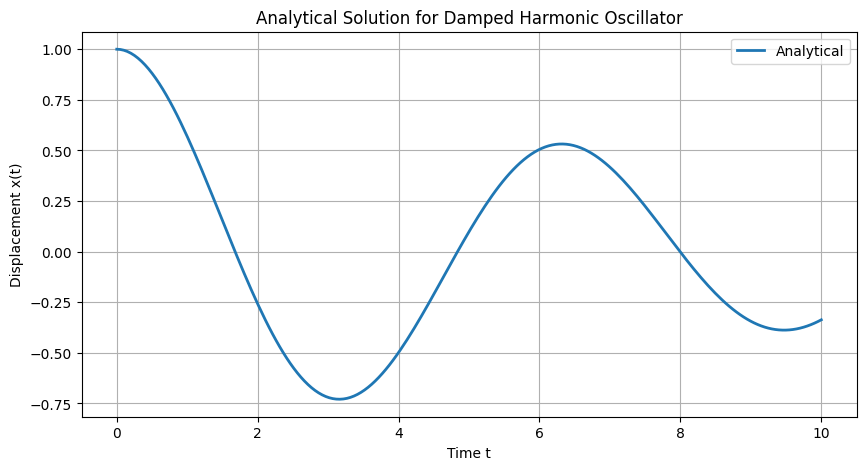

In [113]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_true, label="Analytical", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("Analytical Solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


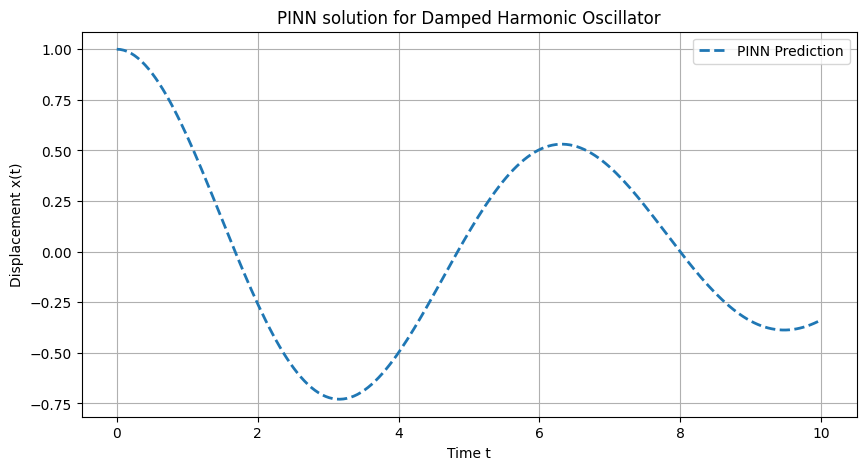

In [114]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_pred_np, '--', label="PINN Prediction", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("PINN solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


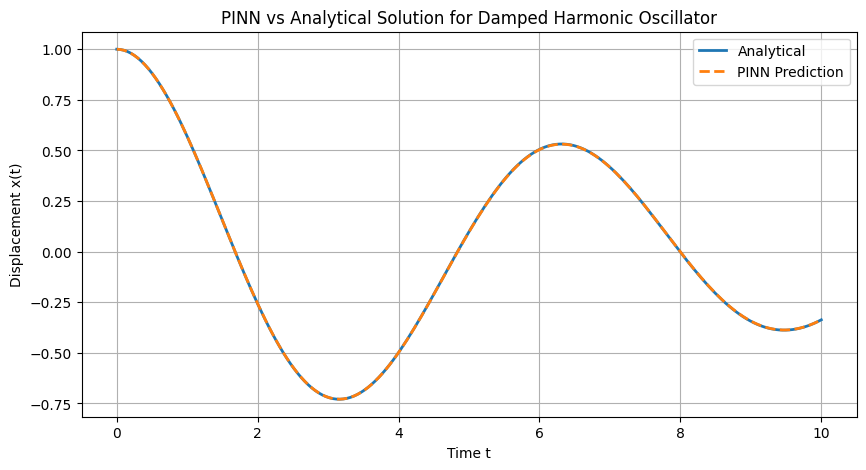

In [118]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_true, label="Analytical", linewidth=2)
plt.plot(t_np, x_pred_np, '--', label="PINN Prediction", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("PINN vs Analytical Solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()
